In [40]:
!pip install -U -q xplique

In [42]:
!pip install shap

     -------------------------------------- 456.1/456.1 kB 5.7 MB/s eta 0:00:00


In [41]:
### IMPORT SECTION
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import tensorflow as tf

import xplique
from xplique.attributions import IntegratedGradients, GuidedBackprop
from xplique.plots import plot_attributions

%matplotlib inline

# Predicting Multi-MNIST digits.

The assignment consists of three tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

3. You can choose between (one of them is mandatory, you can choose which one to do):

*   Use latent representation of autoencoder as a feature reduction
*   Explain Neural Network predictions


The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

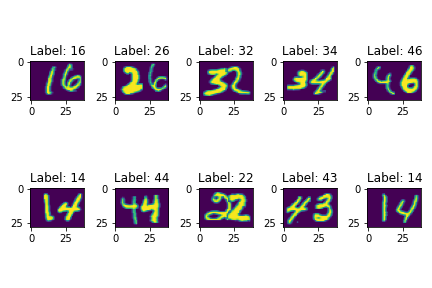

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing,
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions,
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

##Inspecting the data

any comment about data dimensionality/distribution goes here

In [12]:
# Load the .npy files

# created a custom function to:
### read data
### create validation if validation = True
### return dataset
def load_my_data(validation=True):
    X_train = np.load('data/x_train.npy')
    y_train = np.load('data/y_train.npy')
    X_test = np.load('data/x_test.npy')
    y_test = np.load('data/y_test.npy')
    
    if validation:
        # Split the training data further to create a validation set
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        return (X_train, Y_train), (X_val, Y_val), (X_test, y_test)
    else:
        return (X_train, y_train),  (X_test, y_test)
    
(X_train, Y_train), (X_val, Y_val), (X_test, y_test) = load_my_data()    

# checking x_train shape
X_train.shape

(57797, 28, 39)

In [13]:
# label contains integer class values from 1 to 50
class_number = len(set(Y_train))
print('Number of categories:',class_number)
print(set(Y_train))

Number of categories: 50
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}


## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

In [14]:
# recalling the function in order to make this code block idempotent
(X_train, Y_train), (X_val, Y_val), (X_test, y_test) = load_my_data()   

# flattening each 28x39 matrix into a single row of length 1092 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

# converts the pixel values in X_train and X_test from their original integer data type to float32, 
# which is a standard for neural networks.
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")


# Dividing by 255 scales pixel values from their original range of [0, 255] (grayscale)
# to a normalized range of [0, 1]
# Reduces the risk of issues with large gradient values during training, making the model training process more stable
X_train /= 255
X_val /= 255
X_test /= 255


# to_categorical is a function that converts class labels (integers) into one-hot encoded vectors
# ie class 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# to_categorical vectors start from [0, ..., 0] so in order to maintain a relation between digit class and vector class
# i added 1 to the class number in order to represent a class range from 0 to 50
Y_train =  to_categorical(Y_train, class_number+1)
Y_val = to_categorical(Y_val, class_number+1)
Y_test = to_categorical(y_test, class_number+1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


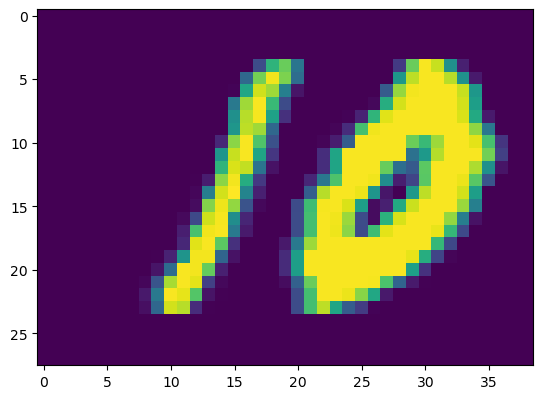

In [15]:
# Comparing train data plot with label encoded as categorical  
plt.imshow(X_train[2].reshape(28, 39))
print(Y_train[2])

# 1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]





You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

## 1.1 Non-regularized Model

In this section, you are required to attempt to solve the classification task with the implementation and training of a standard fully-connected Neural Network, without the use of any specific regularization technique.

### 1.1.1 Building the network


any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. loss/optimizer choice, final activations, loss functions, training metrics and training hyperparameters)

In [16]:
# Define the model
model = Sequential()
# Input layer based on flatten_input_dimension
# use ReLU cause it behave well considering 
### (Avoids Vanishing Gradient, creates sparse represantation, it's computationally efficient)
# Dense layer is a fully-connected one
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))  
model.add(Dense(256, activation='relu'))                       # Hidden layer 1
model.add(Dense(128, activation='relu'))                       # Hidden layer 2
# Output layer
### Softmax is ideal for this because it converts the raw output scores (logits) from the last layer into probabilities 
# for each class, ensuring that the sum of the probabilities across all classes equals 1
model.add(Dense(class_number + 1, activation='softmax'))      

# Compile the model
## choosen Adam as optimizer for its adaptive learning rate 
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
# training the model using a separate set of arrays for the validation
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10


1807/1807 [==============================] - 15s 8ms/step - loss: 0.6985 - accuracy: 0.7958 - val_loss: 0.3797 - val_accuracy: 0.8837
Epoch 2/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.2914 - accuracy: 0.9087 - val_loss: 0.2941 - val_accuracy: 0.9117
Epoch 3/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.2035 - accuracy: 0.9357 - val_loss: 0.2686 - val_accuracy: 0.9221
Epoch 4/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.1587 - accuracy: 0.9488 - val_loss: 0.2827 - val_accuracy: 0.9194
Epoch 5/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1251 - accuracy: 0.9592 - val_loss: 0.2661 - val_accuracy: 0.9256
Epoch 6/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1018 - accuracy: 0.9663 - val_loss: 0.2506 - val_accuracy: 0.9333
Epoch 7/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.0899 - accuracy: 0.9710 - val_loss: 0.2956 - val_

#### Model Analysis: Structure, Hyperparameters, and Training Procedure
###### 1. Network Structure and Layer Choice
Input Layer:

The first layer has 512 neurons and an input shape equal to the flattened input dimension of the MNIST-based images (1092 pixels).
Starting with a large layer (512 neurons) allows the model to capture a wide range of patterns from the input data, which is beneficial for Multi-MNIST where digit combinations are unique. This structure helps capture sufficient complexity in the initial transformation.
Hidden Layers:

Layer 1: 512 neurons
Layer 2: 256 neurons
Layer 3: 128 neurons
The network uses a gradually decreasing number of neurons in each layer, which is common in deep networks for feature extraction and representation learning. This "funnel" shape enables the network to retain essential features while gradually reducing dimensionality, preventing sudden information loss that could impair performance.
Output Layer:

The output layer has as many neurons as the number of classes (class_number + 1) and uses a softmax activation.
Softmax is well-suited for multi-class classification because it outputs class probabilities, ensuring that the sum of probabilities across all classes equals 1. This probabilistic output is desirable for multi-class problems and allows easy interpretation of model predictions.

###### 2. Activation Functions

ReLU (Rectified Linear Unit) is chosen for its advantages:
Efficient Gradient Propagation: ReLU reduces the likelihood of the vanishing gradient problem, allowing faster convergence.
Sparsity: ReLU zeroes out negative values, leading to sparse representations that improve learning by focusing on important features.
Computational Efficiency: ReLU is computationally cheaper than alternatives like sigmoid or tanh, which require more complex operations.

Softmax in the output layer computes probabilities for each class, essential in multi-class problems, converting logits into a distribution over classes.
###### 3. Loss Function
Categorical cross-entropy is the standard choice for multi-class classification problems with one-hot encoded target labels. It measures divergence between the predicted probability distribution and the one-hot label distribution.
This loss function encourages the model to assign high probability to the correct class while minimizing it for incorrect classes, leading to more accurate classification.
###### 4. Optimizer
Adam (Adaptive Moment Estimation) combines the advantages of RMSprop and SGD with momentum. It adapts the learning rate for each parameter based on estimates of first and second moments, improving convergence speed and stability.
Learning Rate: The learning rate of 0.001 is a typical choice for Adam, as its adaptive learning helps prevent the network from getting stuck in local minima and allows faster convergence.
###### 5. Training and Validation Procedure
A batch size of 32 balances memory efficiency and convergence speed. Smaller batch sizes generally lead to noisier gradients, which can help avoid local minima but may slow down convergence.

The choice of 10 epochs reflects an expectation that the model can converge reasonably within a limited number of passes through the data, potentially relying on early stopping to prevent overfitting if more epochs were attempted. More epochs may be useful to explore further improvements if the validation loss hasn’t plateaued.


The use of validation data allows the model to monitor its performance on unseen data during training, helping detect overfitting and guiding hyperparameter adjustments.
###### 6. Metrics
For multi-class classification tasks with balanced classes, accuracy is an appropriate primary metric as it directly reflects the percentage of correct predictions.
###### 7. Training Observations and Recommendations
Regularization: The model doesn’t include explicit regularization techniques like dropout or L2 weight regularization. Adding such techniques can help prevent overfitting, especially for larger networks.

Learning Rate Tuning: While 0.001 is standard, it may be beneficial to experiment with slightly lower or higher learning rates, possibly using a learning rate scheduler to decay the rate over epochs for further performance gains.

Epochs and Early Stopping: 10 epochs may or may not be sufficient for optimal performance. Early stopping based on validation loss or accuracy would be ideal to avoid underfitting (too few epochs) and overfitting (too many epochs).

### 1.1.2 Analyze and comment on thetraining results

Describe, visualize and interpret the training history and the resulting training dynamics.

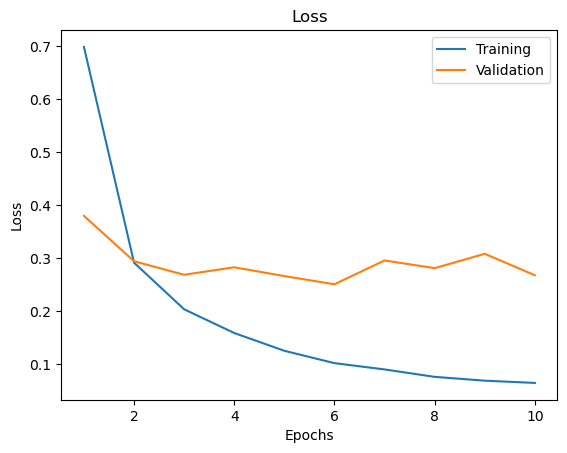

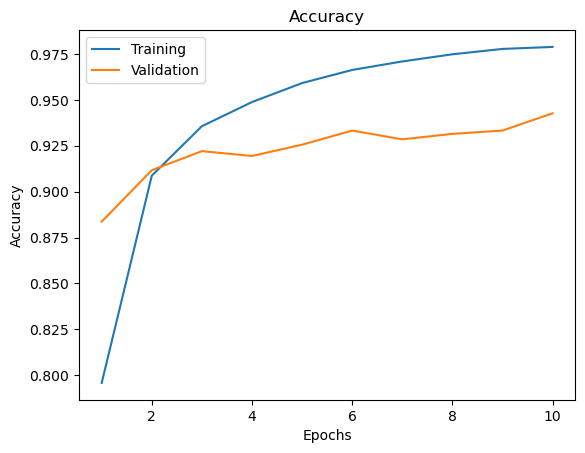

In [17]:
def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

plot_loss(history)
plot_accuracy(history)

### 1.1.3 Validate the model and comment on the results

please describe and interpret the evaluation procedure on a **validation set**, including initial comments on the generalization capability of your model (e.g. under/overfitting).

#### Epochs 1 to 4 (Decreasing Loss for Both Training and Validation):

During the early epochs, both the training and validation losses are decreasing, which is expected behavior. The model is learning from the data, and both the model's predictions on the training data and its generalization to the validation data are improving.
This suggests that the model is initially improving in both fitting the training data and generalizing well to the validation set.

#### After Epoch 4 (Training Loss Continues to Decrease, but Validation Loss Stabilizes):

From this point onward, while the training loss continues to decrease, the validation loss starts to stabilize. This is a sign that the model may have learned the basic patterns of the data and is no longer improving its generalization on the validation set.

The model might be overfitting to the training data. As the model becomes better at fitting the training data, it might start to memorize the details (noise) of the training data, leading to a larger gap between training and validation performance.
The model has learned most of the useful features early on and may need adjustments (e.g., more epochs or regularization) to continue improving its ability to generalize.

#### Final Epochs (Validation Loss Starts to Increase):

If the validation loss starts to increase while the training loss continues to decrease, this is a strong indication that overfitting has begun. The model is becoming too complex and is fitting too closely to the training data, losing its ability to generalize to new, unseen data.

This happens when the model starts memorizing the training data rather than learning the underlying patterns.


#### Other considerations on the overall performance
By the way we have to consider that despite loss and accuracy functions have different behaviour on training and validation data the overall difference is accuracy in quite low

## 1.2 Regularized Model

Replicate the structure of section 1.1 (including subsections 1.1.1, 1.1.2, 1.1.3 and guidelines), this time with the implementation and training of a regularized network.

Implement _at least_ one regularization technique of your choice.

The overall model architecture can be either identical or different with respect to the one presented in sec 1.1 (your choice).

## 1.3. Compare the performances of the two models (non-regularized and regularized) on the provided test set, visualize and comment on theresults

Visualize, describe and interpret the evaluation procedure and results on the provided test set, with a focus on the generalization capability of your models.



### Applying early stopping 

Considering the fact that validation loss started to increase from the epoch 4-5 i've decided to apply an early stopping strategy.
Focusing the training on the early epochs of the previous experiment we got a better accuracy on the test set: 94.32% vs 93.36%.


Epoch 1/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.0668 - accuracy: 0.9793 - val_loss: 0.3095 - val_accuracy: 0.9337
Epoch 2/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.0510 - accuracy: 0.9847 - val_loss: 0.2708 - val_accuracy: 0.9468
Epoch 3/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.0554 - accuracy: 0.9825 - val_loss: 0.3162 - val_accuracy: 0.9388
Epoch 4/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.0484 - accuracy: 0.9849 - val_loss: 0.3413 - val_accuracy: 0.9326
Epoch 5/10
1807/1807 [==============================] - 15s 9ms/step - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.3129 - val_accuracy: 0.9426
Epoch 6/10
1807/1807 [==============================] - 14s 8ms/step - loss: 0.0425 - accuracy: 0.9872 - val_loss: 0.3221 - val_accuracy: 0.9394
753/753 - 3s - loss: 0.2612 - accuracy: 0.9454 - 3s/epoch - 4ms/step
Test accuracy: 94.54%


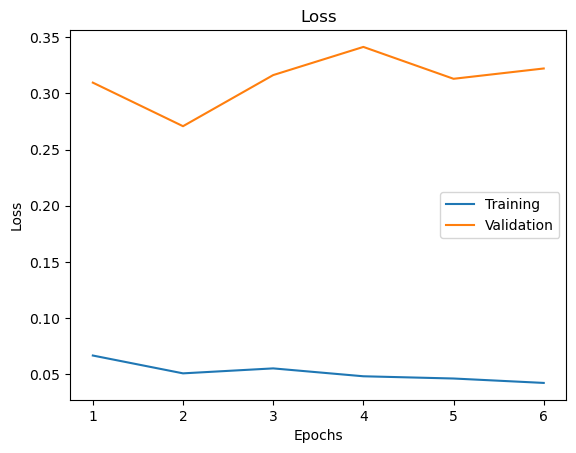

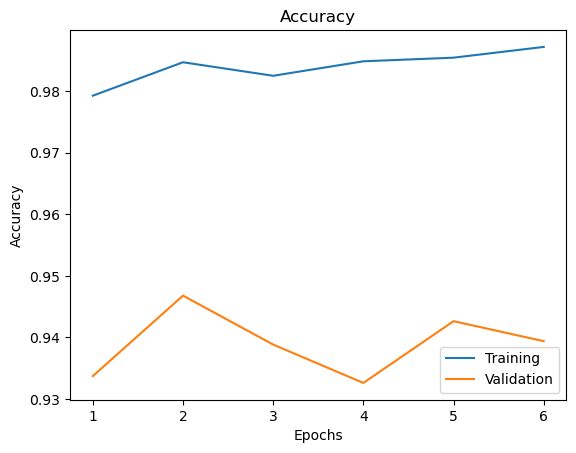

In [18]:
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor (could also be 'val_accuracy')
    patience=4,               # Number of epochs to wait for improvement
    restore_best_weights=True # Restore the model's weights from the epoch with the best validation loss
)

# Compile the model
## choosen Adam as optimizer for its adaptive learning rate 
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
# training the model using a separate set of arrays for the validation
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), 
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

plot_loss(history)
plot_accuracy(history)

### Applying Lasso L1 Regularization

In this experiment, L1 regularization was applied to the model, resulting in a notable shift in the training dynamics. Unlike the model without regularization, the accuracy and loss for both the training and validation sets now follow a more synchronized trend, indicating that the model is less prone to overfitting. However, this regularization comes with a trade-off: the model’s overall performance is slightly lower compared to the non-regularized version. This reduction in accuracy is expected, as L1 regularization imposes a constraint on the model's weights, driving many of them to zero, thereby creating a sparse weight matrix. The sparsity of weights reduces the model’s complexity, helping to generalize better and improving interpretability while modestly impacting peak accuracy.

Next steps could include fine-tuning the regularization strength to find a balance between sparsity and performance.

In [19]:
from keras.regularizers import l1

# Define the model
model_l1 = Sequential()
# Input layer with L1 regularization and ReLU activation
model_l1.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.0001)))  
model_l1.add(Dense(256, activation='relu', kernel_regularizer=l1(0.0001)))  # Hidden layer 1 with L1 regularization
model_l1.add(Dense(128, activation='relu', kernel_regularizer=l1(0.0001)))  # Hidden layer 2 with L1 regularization

# Output layer with Softmax activation
model_l1.add(Dense(class_number + 1, activation='softmax'))      

# Compile the model
model_l1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history_l1 = model_l1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))

# Evaluate the model
test_loss, test_accuracy = model_l1.evaluate(X_test, Y_test, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
1807/1807 [==============================] - 16s 8ms/step - loss: 1.6608 - accuracy: 0.7902 - val_loss: 1.0501 - val_accuracy: 0.8741
Epoch 2/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.8476 - accuracy: 0.8973 - val_loss: 0.7513 - val_accuracy: 0.8987
Epoch 3/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.6513 - accuracy: 0.9158 - val_loss: 0.6205 - val_accuracy: 0.9167
Epoch 4/10
1807/1807 [==============================] - 16s 9ms/step - loss: 0.5662 - accuracy: 0.9266 - val_loss: 0.5794 - val_accuracy: 0.9197
Epoch 5/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.5215 - accuracy: 0.9325 - val_loss: 0.5139 - val_accuracy: 0.9309
Epoch 6/10
1807/1807 [==============================] - 15s 9ms/step - loss: 0.4885 - accuracy: 0.9365 - val_loss: 0.5053 - val_accuracy: 0.9305
Epoch 7/10
1807/1807 [==============================] - 15s 8ms/step - loss: 0.4630 - accuracy: 0.9416 - val_loss: 0.4862 - val_ac

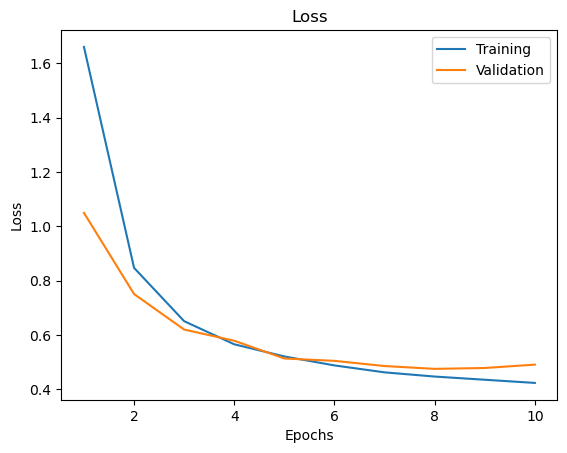

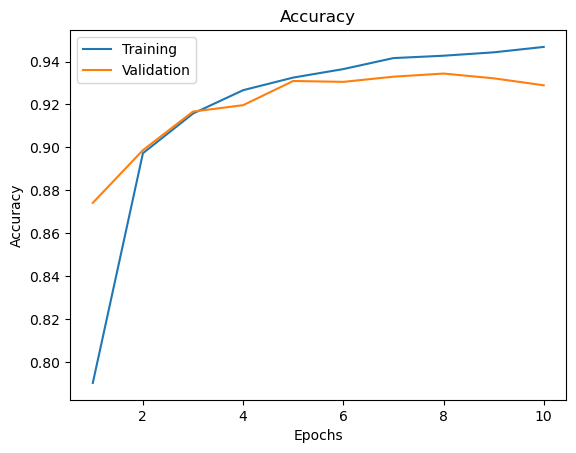

In [20]:
plot_loss(history_l1)
plot_accuracy(history_l1)

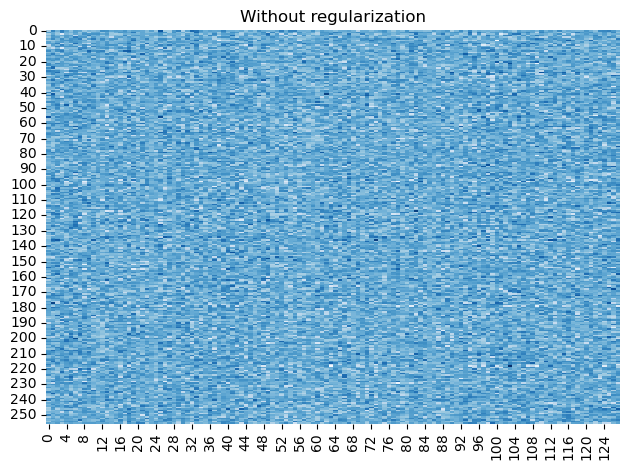

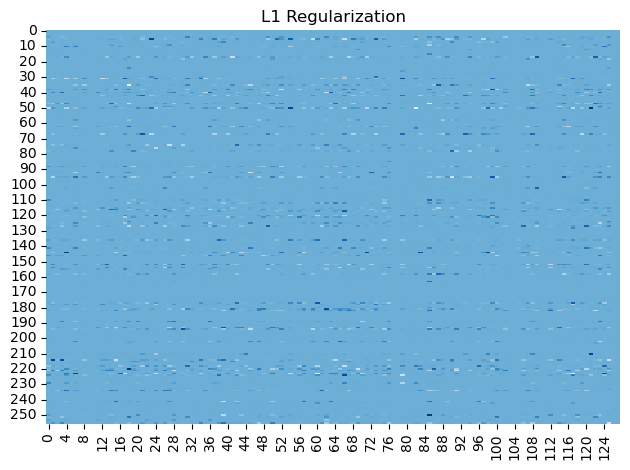

In [21]:
def plot_layer_weights(model, model_name):
    import seaborn as sns


    layer = model.layers[2]
    layer_w_numpy = np.array(layer.get_weights()[0])

    sns.heatmap(layer_w_numpy, cmap="Blues", cbar=False)
    plt.title(model_name)

    plt.tight_layout()

    plt.show()
    
plot_layer_weights(model, "Without regularization")
plot_layer_weights(model_l1, "L1 Regularization")

Based on the results obtained and analyzed during the training and the validation phases, what were your (rather _personal_) expectations with respect to the performances of your models on a blind external test set?

What are the differences between results on the validation set and the actual result on the test set (if any)? What could have caused them? Briefly motivate your answer.

After the comparison, what is the overall "best" model? Why?

For the model that you consider the "best", what are the major sources of error? Are there any classes/labels (or data samples in general) where the model is struggling the most? Why?

#### Expectations for performance on a blind external test set:

For the model without regularization, the divergence between training and validation accuracy (where validation accuracy plateaued while training accuracy continued increasing) suggested potential overfitting. Thus, I would expect it to generalize less effectively on a blind test set, possibly resulting in a lower test accuracy than seen during training.
For the early stopping model, which demonstrated more stable accuracy trends across training and validation, I anticipated that it would generalize better, as it reduced overfitting by halting training at an optimal point. This made it more likely to yield a higher and more stable accuracy on the test set.
For the L1-regularized model, the consistency between training and validation trends indicated strong regularization and sparse feature selection (as it's possible to see the sparsity in the plot above). However, the slight decrease in accuracy suggested some underfitting, which might result in a slightly lower test accuracy compared to the early stopping model. The L1 regularization would help maintain generalization, but the impact on accuracy might be more pronounced on new, unseen data.


#### Differences between validation and test results (if any) and potential causes:

The early stopping model’s training accuracy (94.32%) follow the same trend of validation accuracy but the validation accuracy is always lower than training accuracy. However this result is in contrast with the fact that this model achieved the best test score.

The L1-regularized model’s test accuracy (92.72%) being slightly lower than the early stopping model suggests that the sparsity introduced by L1 regularization reduced its ability to capture all features relevant to test data. This may have limited its adaptability to certain patterns or nuances in the unseen data.

The model without regularization achieved 93.36% test accuracy, which is lower than the early stopping model. This drop in performance aligns with expectations that overfitting in training could lead to decreased generalization on unseen data.

#### Overall best model and areas of struggle:

The early stopping model appears to be the best overall due to its high test accuracy (94.32%) by the way the differences registered between tranining and validation accuracy suggest that this model should be tested and validated better on bigger set of unseen data. Furthemore other validation techniques like cross-validation could be tried.

# 2. The development of a simple auto-encoder model  [Mandatory]
Implement a fully-connected AutoEncoder architecuture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**.


Visually investigate the reconstruction abilities of such an architecture, e.g. comparing a few inputs and outputs (reconstructed inputs) of the model (as seen in class).

## 2.1 Building the network

note: although not strictly required, monitoring the training dynamics and performance evaluation is suggested for the autoencoder model.

#### Autoencoder Architecture Design Choices

##### Set Encoding Dimension
- **Encoding Dimension**: The `encoding_dim` is set to 40, aiming for a compression factor of approximately 27 (1092 / 40 ≈ 27).
- **Purpose**: This dimension was chosen to create a low-dimensional latent space that can capture meaningful patterns from the input while discarding noise. It balances compression with the risk of losing too much information, which would hinder reconstruction accuracy.

#####  Activation Function
- **Activation Function**: ReLU (`activation="relu"`) is used in all hidden layers.
- **Reason**: ReLU is popular in deep learning for its simplicity and ability to mitigate the vanishing gradient problem, enabling efficient training. It also creates sparse representations, which can help focus on important features.

#####  Input Layer
- **Input Shape**: `Input(shape=(1092,))`, where 1092 corresponds to the flattened dimensionality of the original data.
- **Purpose**: It provides a placeholder for input vectors of size 1092, which represents each sample's features after flattening.

#####  Downsampling Hidden Layers
- **Layer 1**: `Dense(256, activation=activation, name="downsampling_hidden_1")`
- **Layer 2**: `Dense(128, activation=activation, name="downsampling_hidden_2")`
- **Purpose**: These layers reduce the input dimensionality gradually, moving towards the compressed `encoding_dim` layer. They act as intermediate transformations, allowing the model to capture increasingly abstract features as data moves through these layers.

#####  Encoded Layer (Latent Representation)
- **Encoded Layer**: `Dense(encoding_dim, activation=activation, name="latent")`
- **Purpose**: This layer produces the latent representation or bottleneck, which is the compressed form of the input. It serves as the feature space from which the input will be reconstructed, and it captures key patterns in the data at a reduced dimensionality.

#####  Upsampling Hidden Layers
- **Layer 1**: `Dense(128, activation=activation, name="upsampling_hidden_1")`
- **Layer 2**: `Dense(256, activation=activation, name="upsampling_hidden_2")`
- **Purpose**: These layers gradually expand the compressed representation back towards the original dimension. They are symmetric with the downsampling layers, helping to reconstruct the input data from the latent representation by reversing the transformations applied during encoding.

#####  Output Layer
- **Layer**: `Dense(1092, activation='sigmoid', name="decoder")`
- **Activation Function**: Sigmoid is chosen for the output layer to ensure each reconstructed pixel is in the range [0, 1].
- **Purpose**: This layer aims to map the output back to the original input dimensions. Since the original input was scaled, sigmoid is appropriate to produce values in a similar range, completing the reconstruction process.

#####  Model Compilation and Summary
- **Model Compilation**: 
  - **Optimizer**: Adam optimizer, known for its adaptive learning rate, was selected for efficient convergence.
  - **Loss Function**: Binary cross-entropy is used as it aligns well with the scaled pixel values in the data (values between 0 and 1).



In [22]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Set encoding dimension within desired compression factor range
encoding_dim = 40  # Approximate compression factor of 27

# Define activation function
activation = "relu"

# Input placeholder
input_layer = Input(shape=(1092,))

# Downsampling hidden layers
downsampling_hidden_1 = Dense(256, activation=activation, name="downsampling_hidden_1")(input_layer)
downsampling_hidden_2 = Dense(128, activation=activation, name="downsampling_hidden_2")(downsampling_hidden_1)

# Encoded layer - latent representation
encoded = Dense(encoding_dim, activation=activation, name="latent")(downsampling_hidden_2)

# Upsampling hidden layers
upsampling_hidden_1 = Dense(128, activation=activation, name="upsampling_hidden_1")(encoded)
upsampling_hidden_2 = Dense(256, activation=activation, name="upsampling_hidden_2")(upsampling_hidden_1)

# Output layer
decoded = Dense(1092, activation='sigmoid', name="decoder")(upsampling_hidden_2)

# Model - maps input to its reconstruction
autoencoder = Model(input_layer, decoded)

# Summary of the autoencoder architecture
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1092)]            0         
                                                                 
 downsampling_hidden_1 (Den  (None, 256)               279808    
 se)                                                             
                                                                 
 downsampling_hidden_2 (Den  (None, 128)               32896     
 se)                                                             
                                                                 
 latent (Dense)              (None, 40)                5160      
                                                                 
 upsampling_hidden_1 (Dense  (None, 128)               5248      
 )                                                               
                                                           

In [23]:
# this model maps an input to its encoded representation
encoder_model = Model(input_layer, encoded)
encoder_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1092)]            0         
                                                                 
 downsampling_hidden_1 (Den  (None, 256)               279808    
 se)                                                             
                                                                 
 downsampling_hidden_2 (Den  (None, 128)               32896     
 se)                                                             
                                                                 
 latent (Dense)              (None, 40)                5160      
                                                                 
Total params: 317864 (1.21 MB)
Trainable params: 317864 (1.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
## SUBMODEL FOR THE DECODER

# create the decoder model
decoder_model = Model(encoded, decoded)

decoder_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 upsampling_hidden_1 (Dense  (None, 128)               5248      
 )                                                               
                                                                 
 upsampling_hidden_2 (Dense  (None, 256)               33024     
 )                                                               
                                                                 
 decoder (Dense)             (None, 1092)              280644    
                                                                 
Total params: 318916 (1.22 MB)
Trainable params: 318916 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# compiling the autoencoder model

autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics = ["mse"])
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1092)]            0         
                                                                 
 downsampling_hidden_1 (Den  (None, 256)               279808    
 se)                                                             
                                                                 
 downsampling_hidden_2 (Den  (None, 128)               32896     
 se)                                                             
                                                                 
 latent (Dense)              (None, 40)                5160      
                                                                 
 upsampling_hidden_1 (Dense  (None, 128)               5248      
 )                                                               
                                                           

In [26]:
# Training autoencoder model, this also affects the submodels that are pointer to the whole autoencoder
network_history = autoencoder.fit(X_train,X_train,
                epochs=100,
                batch_size=1024,
                shuffle=True,
                validation_split=0.1)

Epoch 1/100
51/51 [==============================] - 3s 42ms/step - loss: 0.4196 - mse: 0.1070 - val_loss: 0.3537 - val_mse: 0.0841
Epoch 2/100
51/51 [==============================] - 2s 37ms/step - loss: 0.3244 - mse: 0.0741 - val_loss: 0.2980 - val_mse: 0.0648
Epoch 3/100
51/51 [==============================] - 2s 39ms/step - loss: 0.2769 - mse: 0.0576 - val_loss: 0.2600 - val_mse: 0.0516
Epoch 4/100
51/51 [==============================] - 2s 41ms/step - loss: 0.2490 - mse: 0.0479 - val_loss: 0.2400 - val_mse: 0.0446
Epoch 5/100
51/51 [==============================] - 2s 41ms/step - loss: 0.2335 - mse: 0.0425 - val_loss: 0.2286 - val_mse: 0.0407
Epoch 6/100
51/51 [==============================] - 2s 37ms/step - loss: 0.2230 - mse: 0.0388 - val_loss: 0.2200 - val_mse: 0.0377
Epoch 7/100
51/51 [==============================] - 2s 39ms/step - loss: 0.2161 - mse: 0.0365 - val_loss: 0.2149 - val_mse: 0.0361
Epoch 8/100
51/51 [==============================] - 2s 36ms/step - loss: 0.

51/51 [==============================] - 2s 34ms/step - loss: 0.1629 - mse: 0.0185 - val_loss: 0.1640 - val_mse: 0.0187
Epoch 63/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1628 - mse: 0.0184 - val_loss: 0.1645 - val_mse: 0.0189
Epoch 64/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1626 - mse: 0.0184 - val_loss: 0.1645 - val_mse: 0.0189
Epoch 65/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1624 - mse: 0.0183 - val_loss: 0.1638 - val_mse: 0.0186
Epoch 66/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1625 - mse: 0.0183 - val_loss: 0.1636 - val_mse: 0.0185
Epoch 67/100
51/51 [==============================] - 2s 35ms/step - loss: 0.1621 - mse: 0.0182 - val_loss: 0.1643 - val_mse: 0.0187
Epoch 68/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1622 - mse: 0.0182 - val_loss: 0.1637 - val_mse: 0.0186
Epoch 69/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1619 

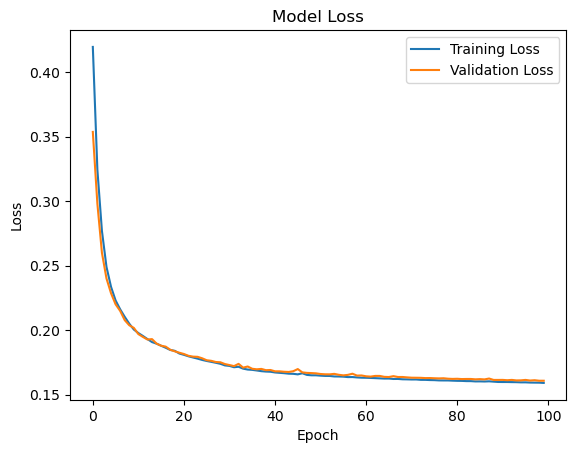

In [28]:
# Plot Training and Validation Loss

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(network_history.history['loss'], label='Training Loss')
plt.plot(network_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [63]:
from sklearn.metrics import mean_squared_error

# Generate reconstructed test data from the autoencoder
X_test_pred = autoencoder.predict(X_test)
X_train_pred = autoencoder.predict(X_train)

# Calculate Mean Squared Error (MSE) across all samples
mse_test = mean_squared_error(X_test, X_test_pred)
mse_train = mean_squared_error(X_train, X_train_pred)

print(f"Mean Squared Error on Test Data: {mse_test:.4f}")
print(f"Mean Squared Error on Train Data: {mse_train:.4f}")

1807/1807 [==============================] - 5s 3ms/step
Mean Squared Error on Test Data: 0.0175
Mean Squared Error on Train Data: 0.0172


753/753 [==============================] - 3s 4ms/step


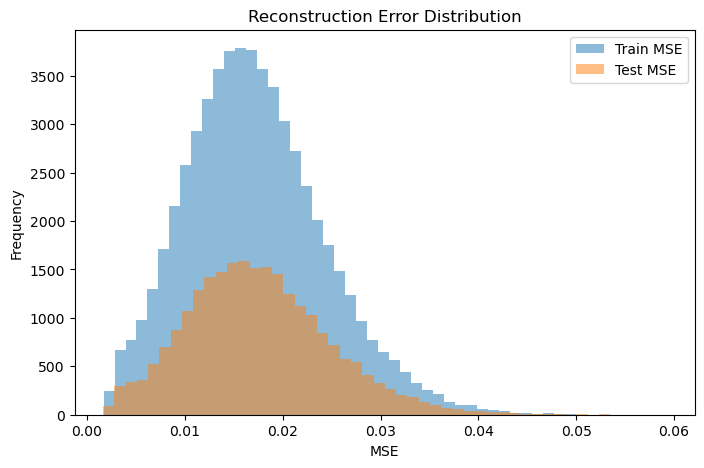

In [29]:
# Evaluate Model with Reconstruction Error
# The reconstruction error is the difference between the original data and its reconstruction by the autoencoder.

import numpy as np

# Generate reconstructed data
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# Calculate mean squared error for each data point in training and test sets
train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Plot reconstruction error distribution
plt.figure(figsize=(8, 5))
plt.hist(train_mse, bins=50, alpha=0.5, label='Train MSE')
plt.hist(test_mse, bins=50, alpha=0.5, label='Test MSE')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()


###### MSE Values Between
Low Reconstruction Error: The fact that both the training and test MSE values are related to low values (0.0175 for test set and 0.0172 for training set) suggests that the autoencoder is performing well, as the reconstruction errors are relatively small.
Performance on Both Training and Test Data: it indicates that the autoencoder is able to accurately reconstruct the data. A low MSE means that the original and reconstructed data are very similar, and the model is able to capture most of the variance and patterns present in the input data.
###### Similarity of Training and Test MSE Distributions
Good Generalization: The fact that the distributions for both training and test data are very similar is a positive sign, as it suggests the model is not overfitting to the training set. If the training set MSE were significantly lower than the test set, it could indicate overfitting—where the model memorizes the training data and doesn’t generalize well to new, unseen data.
Balanced Performance: The similarity in distributions indicates that the model is not too biased towards the training data and is learning generalized features that also apply to the test set.
###### Test MSE Slightly Shifted to the Right
Slight Increase in Test MSE: The small shift of the test MSE distribution to the right suggests that the autoencoder is performing marginally worse on the test data compared to the training data. This could be due to several factors:
Generalization Gap: The model may perform slightly worse on unseen data (test data), which is common, especially when models are trained on a limited dataset or when the data has subtle complexities that the model hasn’t fully captured.
Model Limitation: The model may have overfitted to the training data to some extent, but this overfitting is mild, as indicated by the slight shift rather than a drastic change.
###### Implications for Model Performance
Overall Robustness: The slight shift in the test MSE distribution does not likely indicate a severe issue but points to a small generalization gap between the training and test sets. 

###### Summary:
Positive Aspects: Both training and test distributions show low MSE, indicating that the autoencoder is performing well in terms of reconstruction. The similar distributions imply that the model is generalizing well and not overfitting to the training data.
Minor Concerns: The slight shift to the right in the test MSE distribution suggests a minor generalization gap. 

## 2.2 Visually Inspecting the results

Investigate the reconstruction capabilities of autoencoders by comparing (in a multi-column plot) the visual representation of some input data (5 to 10 samples) with the reconstruction of such samples (output of the autoencoder).

753/753 [==============================] - 2s 2ms/step


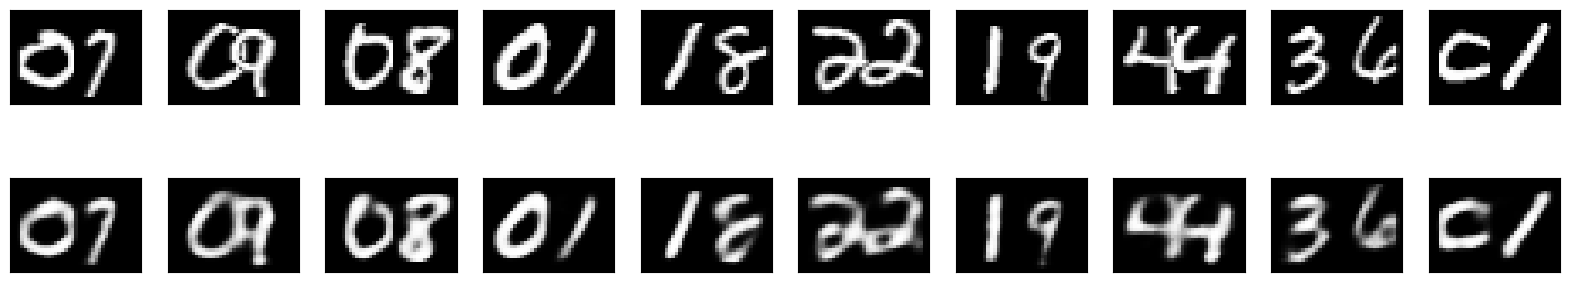

In [27]:
# Testing the Autoencoder:

from matplotlib import pyplot as plt
%matplotlib inline

x_selected = X_test
encoded_imgs = encoder_model.predict(x_selected)
decoded_imgs = decoder_model.predict(encoded_imgs)

#autoencoder.predict(x_selected)
#alternative here?
#decoded_imgs = autoencoder.predict(x_selected)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_selected[i].reshape(28, 39))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 39))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2.3 Generate new samples

Starting from random encodings, generate $N$ ($N \in [10,20]$) new samples, and make some comments about the quality and distribution of the generated samples.

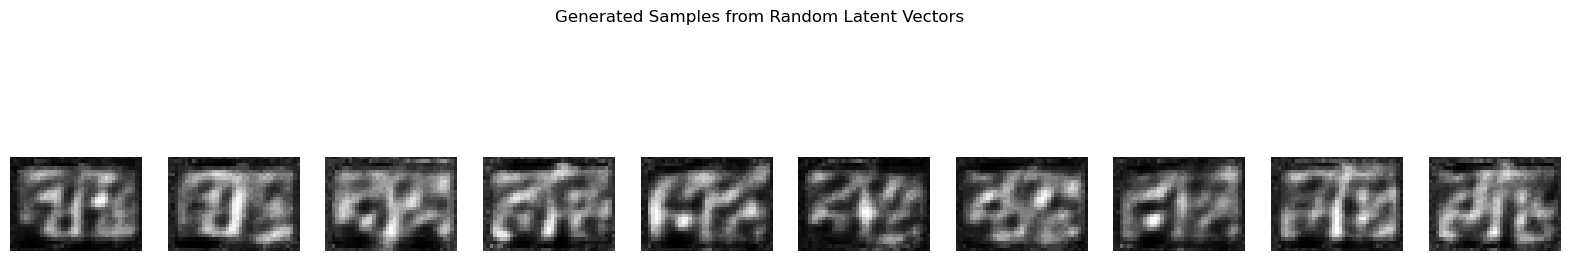

In [36]:
# Number of new samples to generate
N = 10  # Choose any value between 10 and 20

# Generate N random latent vectors in the same range as the latent space
random_latent_vectors = np.random.normal(size=(N, encoding_dim))  # encoding_dim = 40

# Decode the random latent vectors to generate new samples
generated_samples = decoder_model(random_latent_vectors).numpy()

# Visualize some of the generated samples
plt.figure(figsize=(20, 4))
for i in range(N):
    plt.subplot(1, N, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 39), cmap='gray')  # Adjust shape as per your data
    plt.axis('off')

plt.suptitle("Generated Samples from Random Latent Vectors")
plt.show()


### Some considerations about the "(Poor) Generated Samples from Random Latent Vectors"

##### Latent Space Structure
In autoencoders, the latent space (or encoding space) is typically learned in such a way that it maps to meaningful features of the input data. However, this structure is specific to the patterns present in the training data, and not all points in the latent space will correspond to realistic inputs. So, starting from random latent points doesn’t guarantee meaningful decoded outputs, since the model is trained only to encode and decode within a structured, data-specific region of the latent space.

##### Autoencoder Focus
Autoencoders do not enforce a smooth, continuous latent space that covers all possible representations of the input data. This is especially true if the autoencoder wasn’t specifically trained to handle generative tasks (e.g., like a Variational Autoencoder, or VAE, which does enforce a continuous and dense latent space).

##### Interpretation of Poor Decodes
Poor-quality decodes from random points can actually give insights into how the autoencoder organizes the latent space. If random points do not yield coherent images, it indicates that the model’s latent space is sparse, with only certain regions corresponding to realistic outputs.

### Restricted Sampling 
Instead of sampling randomly, this time we're starting with encodings from the training data and slightly perturbing them. This allows to explore nearby points within the latent space where the autoencoder has seen data, increasing the likelihood of producing coherent outputs.

1/1 [==============================] - 0s 28ms/step


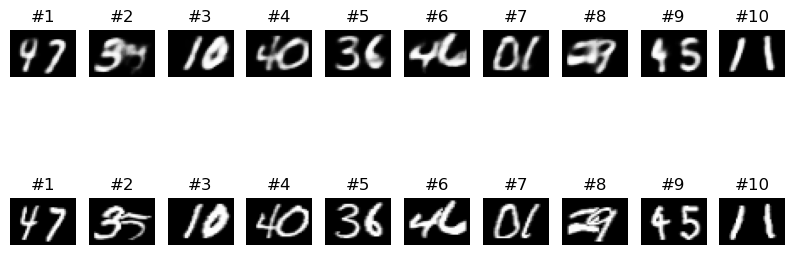

In [39]:
# Number of samples to generate
N = 10  # You can choose a number between 10 and 20
perturbation_scale = 0.05  # Adjust this to control the level of perturbation

# Step 1: Encode a subset of the training data
# Use the encoder model (encoder_model) to get the latent representations of some samples
encoded_samples = encoder_model.predict(X_train[:N])

# Step 2: Add slight perturbations to the encoded samples
perturbed_encodings = encoded_samples + np.random.normal(scale=perturbation_scale, size=encoded_samples.shape)

# Step 3: Decode the perturbed encodings to generate new samples
generated_samples = decoder_model.predict(perturbed_encodings)

# Step 4: Visualize the generated samples to evaluate quality and distribution
plt.figure(figsize=(10, 4))
for i in range(N):
    # Plot the generated sample
    ax = plt.subplot(2, N, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 39), cmap='gray')  # Adjust shape for your data dimensions
    plt.axis('off')
    plt.title(f"#{i+1}")

    # Plot the original sample for comparison
    ax = plt.subplot(2, N, N + i + 1)
    plt.imshow(X_train[i].reshape(28, 39), cmap='gray')  # Adjust shape for your data dimensions
    plt.axis('off')
    plt.title(f"#{i+1}")

plt.show()


# 3.A [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.

1. Obtain `X_train_encoded`, `X_test_encoded`, the latent (encoded) representations of `X_train` and `X_test` generated by the (encoder module of the) autoencoder developed in Section 2.

2. With the use of any classic machine learning method of your choice (avoid NNs), classify letters as in Sec.1 based on this representation.

3. Apply the same type of ML algorithm chosen in pt.2, but directly on the original data `X_train`, `X_test` (or you can use suitable dimensionality reduction methods if the chosen algorithm is known to require them or benefit from them).  

4. Compare (briefly) the performances on the test set, between the best model of Sec.1, the ML model trained on `X_train_encoded` and the ML model trained on `X_train` (or any other suitable representation that you choose in pt.3).


In other words, instead of feeding images directly through a classifier, you can try to use the encoded representations from the AE as input for a classic ML algorithm (XGB, SVM, RF ...) to solve the classification task.


In [51]:
### Encode the Data with the Autoencoder

# Generate latent (encoded) representations for training and test data
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

753/753 [==============================] - 1s 2ms/step


In [52]:
### Select a Classic ML Algorithm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the model on the encoded (latent) representation
clf_encoded = RandomForestClassifier(random_state=42)
clf_encoded.fit(X_train_encoded, Y_train)

# Make predictions and evaluate
Y_pred_encoded = clf_encoded.predict(X_test_encoded)
accuracy_encoded = accuracy_score(Y_test, Y_pred_encoded)
print(f"Accuracy on Encoded Data: {accuracy_encoded * 100:.2f}%")

Accuracy on Encoded Data: 20.57%


In [53]:
### Train the Same ML Algorithm on Original Data

# Train on original data
clf_original = RandomForestClassifier(random_state=42)
clf_original.fit(X_train, Y_train)

# Make predictions and evaluate
Y_pred_original = clf_original.predict(X_test)
accuracy_original = accuracy_score(Y_test, Y_pred_original)
print(f"Accuracy on Original Data: {accuracy_original * 100:.2f}%")

Accuracy on Original Data: 45.41%


accuracy_score for 10: 0.31922933189386704
accuracy_score for 20: 0.34094589544491966
accuracy_score for 50: 0.26184445459452727


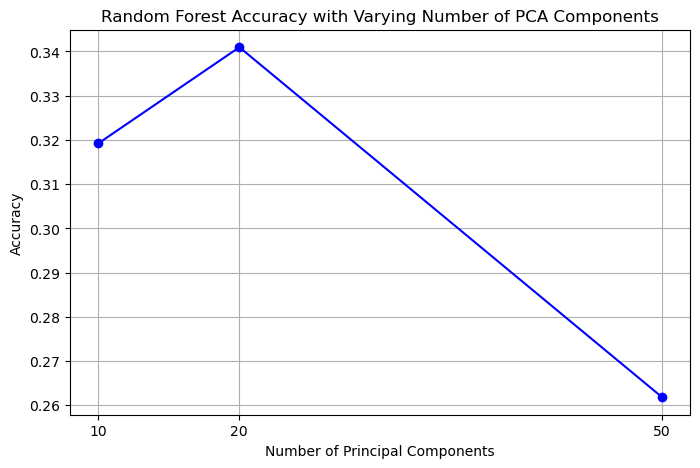

In [66]:
from sklearn.decomposition import PCA

# Set the number of principal components to retain
# Define range of n_components to test
components_range = [10, 20, 50] 
accuracies = []

# Train and evaluate RandomForest for each value of n_components
for n_components in components_range:
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA and transform both training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train RandomForest on PCA-reduced data
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_pca, Y_train)
    
    # Make predictions and calculate accuracy
    Y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"accuracy_score for {n_components}: {accuracy}")
    
    # Append the accuracy to the list
    accuracies.append(accuracy)

# Plotting the accuracies
plt.figure(figsize=(8, 5))
plt.plot(components_range, accuracies, marker='o', color='b', linestyle='-', markersize=6)
plt.title("Random Forest Accuracy with Varying Number of PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [58]:
!pip install xgboost


     -------------------------------------- 124.9/124.9 MB 5.9 MB/s eta 0:00:00


In [60]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Encode the data with the Autoencoder
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)


# 2. Train XGBoost on Encoded Data
### XGBoost is a gradient-boosting model that can be highly effective on complex datasets.
print("Training XGBoost on Encoded Data...")
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_encoded, Y_train)

# Make predictions and evaluate
Y_pred_xgb_encoded = xgb_clf.predict(X_test_encoded)
accuracy_xgb_encoded = accuracy_score(Y_test, Y_pred_xgb_encoded)
print(f"Accuracy of XGBoost on Encoded Data: {accuracy_xgb_encoded * 100:.2f}%")


753/753 [==============================] - 1s 2ms/step
Training XGBoost on Encoded Data...


C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBoost on Encoded Data: 61.18%


In [62]:
# 2. Train XGBoost on Original Data
### XGBoost is a gradient-boosting model that can be highly effective on complex datasets.
print("Training XGBoost on Original Data...")
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, Y_train)

# Make predictions and evaluate
Y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
print(f"Accuracy of XGBoost on Encoded Data: {accuracy_xgb * 100:.2f}%")

Training XGBoost on Original Data...


C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBoost on Encoded Data: 78.13%


#### Analysis of the results

######  Performance on Encoded Data (Random Forest vs XGBoost)

Random Forest on Encoded Data:
Accuracy: 20.57%
Interpretation:
The performance of Random Forest on the encoded data was low, achieving an accuracy of 20.57%. This result suggests that Random Forest struggled to effectively classify the data after it was passed through the autoencoder. Several factors may explain this outcome:
Loss of Information in Encoding: The autoencoder, while reducing dimensionality, may have compressed the data too much, losing critical features necessary for accurate classification. The latent space generated by the autoencoder may not have preserved enough discriminative information for Random Forest to build meaningful decision trees.
Nature of Encoded Representations: The encoded features might not have been as informative for Random Forest, which relies on clear decision boundaries and feature importance. The autoencoder might have learned features that are not as easily interpreted by Random Forest, leading to poor classification performance.
Random Forest’s Sensitivity to Feature Variance: Random Forest performs best when features exhibit high variance. If the encoded features do not exhibit sufficient variance, the model may fail to create accurate splits, resulting in poor performance.
More in general, Random Forests usually don’t perform well on image data unless the images are first transformed into structured, feature-rich representations. They don't directly handle the spatial relationships in image pixels.

XGBoost on Encoded Data:
Accuracy: 61.18%
Interpretation:
XGBoost demonstrated a much better performance on the encoded data, achieving an accuracy of 61.18%. This improvement suggests that XGBoost was able to utilize the encoded features more effectively than Random Forest.
XGBoost’s Ability to Capture Non-linearities: XGBoost is well-suited for handling complex, non-linear relationships within the data. The latent features, despite being compressed, likely still contained non-linear patterns that XGBoost could exploit to improve classification performance.
Boosting Approach: XGBoost’s boosting technique, which combines the output of multiple weak learners, likely helped it overcome any challenges posed by the encoded data. This iterative process allowed the model to refine its predictions and better adapt to the structure of the latent space.

###### Performance on Original Data (Random Forest vs XGBoost)

Random Forest on Original Data:
Accuracy: 45.41%
Interpretation:
When trained on the original data, Random Forest achieved an accuracy of 45.41%, which is a notable improvement compared to its performance on the encoded data. This suggests that Random Forest was better able to leverage the rich, high-dimensional features in the raw data.
Feature Richness in Original Data: The original data likely contained more discriminative features, allowing Random Forest to create more effective decision trees. These features might have been essential for making accurate classifications, which was reflected in the higher accuracy.
Separation of Classes: The original data may have had better-defined class boundaries, making it easier for Random Forest to distinguish between classes, leading to improved performance.

XGBoost on Original Data:
Accuracy: 78.13%
Interpretation:
XGBoost achieved the highest accuracy of 78.13% when trained directly on the original data. This is consistent with expectations, as XGBoost is highly effective at handling high-dimensional, complex datasets.
Modeling Complex Relationships: XGBoost’s strength lies in its ability to model complex feature interactions and non-linear relationships, which allowed it to perform well on the original, high-dimensional data.
Feature Interaction Modeling: XGBoost’s boosting method iteratively refines the model by focusing on previously misclassified examples. This mechanism likely helped it identify complex patterns in the original data, resulting in superior classification performance.

###### Comparative Performance:
The results clearly show a difference in performance when comparing models trained on the encoded data versus the original data. The key findings are as follows:

On Encoded Data:
XGBoost (61.18%) outperforms Random Forest (20.57%) on the encoded data. This suggests that XGBoost was better able to extract useful information from the latent features, while Random Forest struggled with the simplified data.
Random Forest’s low performance on the encoded data indicates that the encoding might have simplified the data too much, removing important patterns necessary for decision tree-based models.

On Original Data:
XGBoost (78.13%) again outperforms Random Forest (45.41%) when trained on the original data, highlighting XGBoost’s superior ability to handle high-dimensional, complex data.
Random Forest’s improvement in performance when using the original data indicates that it was able to better exploit the detailed, high-dimensional features, although it still lagged behind XGBoost.

Another point to consider is that all the experiments have been conducted without hyperparameters fine-tuning.

###### Conclusion and Insights:
XGBoost’s Strengths: 
The higher performance of XGBoost across both encoded and original data suggests that it is a more effective algorithm for the classification task, particularly in capturing non-linear relationships and complex feature interactions. XGBoost was able to leverage the encoded features more effectively than Random Forest and outperformed Random Forest on the original data as well.

Random Forest’s Limitations with Encoded Data: 
The poor performance of Random Forest on the encoded data suggests that the latent features may not have preserved enough important information for decision trees to make accurate predictions. However, Random Forest performed better on the original data, where it could utilize the richer feature set.

Impact of Dimensionality Reduction: Although the autoencoder provided a reduced-dimensional representation of the data, it appears that some useful features may have been lost during the encoding process. XGBoost still performed well with these encoded features, but the original data provided a clearer structure for both classifiers.

In summary, XGBoost demonstrated superior performance in all scenarios, making it the most effective model for this classification task. While Random Forest benefited from the original data, XGBoost was able to adapt better to both the raw and encoded data, outperforming Random Forest in all cases. The results suggest that directly working with the original data may lead to better results in this case.



# 3.B [OPTIONAL] Explain model's predictions

Take the networks defined in (1) and try to explain the predictions of the model.

*   Include at least one model-agnostic method and one model-specific method;
*   Compare the two investigated XAI methods;
*   Compare the results on the original and regularized model for a single XAI method;

### 3.B.1 XAI method definition

Describe the design choices made at this stage: why did you choose these two methods?

### 3.B.2 Result's comparison

Compare the results of both XAI methods and the results of applying the same method to different models.